In [1]:
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset

/Users/leakycauldron/miniconda3/envs/whisper/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:

#get spectrograms from dataset instance
def get_spectrogram(instance):
    array = instance['audio']["array"]
    samples_per_second = instance['audio']["sampling_rate"]
    num_audio_samples = array.shape[0]
    spectrogram_frames_per_second = 100 # whisper constant
    num_spectrogram_frames = num_audio_samples * spectrogram_frames_per_second // samples_per_second +1
    return  processor(array, sampling_rate=samples_per_second, return_tensors="pt").input_features[0,:,:num_spectrogram_frames]
#get tokens from dataset instance
def get_decoder_input_ids(instance):
    return torch.LongTensor([processor.tokenizer(instance['text']).input_ids])


def build_saliency_mask(saliency: torch.Tensor, r=.5, balanced=True, translucent=True):
    k = int(r * saliency.numel())
    saliency_abs : torch.Tensor = saliency.abs()
    if translucent:
        if balanced:
            return saliency_abs.softmax(dim=0)
        return saliency_abs.flatten().softmax(dim=0).reshape(saliency_abs.shape)
    if balanced:
        return (saliency_abs >= saliency_abs.T.topk(k //(saliency.shape[-1])).values.min(dim=-1).values)
    return (saliency_abs >= saliency_abs.flatten().topk(k).values.min())

def mask_unsalient_features(features: torch.Tensor, mask):
    '''
    For some reason, the ambient intensity of whisper spectrograms is slightly negative and differs slightly between instances
    This method applies a mask that matches the ambient intensity
    '''
    ambient_intensity = features.min()
    return  (
                (features - ambient_intensity)  # Shift ambient intensity to 0 ...
                * mask                          # ... then mask ...
                + ambient_intensity             # ... then shift back
            )

def pad_for_whisper(features):
    '''
    Whisper only accepts tensors of shape [B, 80, 3000]
    '''
    desired_shape = (80, 3000)
    ambient_intensity = features.min()
    padding = [max(0, desired_shape[i] - features.shape[i]) for i in range(2)]
    padded_tensor = torch.nn.functional.pad(features, (0, padding[1], 0, 0), mode='constant', value=float(ambient_intensity))
    return padded_tensor[None]

def build_saliency_map(features : torch.Tensor, decoder_input_ids):
    '''
    '''
    #Get inputs for model
    features.requires_grad = True
    input_features = pad_for_whisper(features)
    #Get output logits at each time step
    model_output = model.forward(input_features, decoder_input_ids=decoder_input_ids)
    logits = model_output.logits[0]
    #Sum up the logits for the predicted tokens at each step
    total = logits.gather(1, decoder_input_ids.T).sum() # # # # # total = logits.gather(1, logits.argmax(dim=1)[None].T).sum() # # # # # should we use gold tokens or predicted tokens ?
    #backward pass
    total.backward(retain_graph=True)
    return features.grad

def transcribe(features):
    return processor.batch_decode(model.generate(pad_for_whisper(features)), skip_special_tokens=True)[0]

def top_r_features(instance, r=.25, balanced=True):
    features : torch.Tensor = get_spectrogram(instance)
    decoder_input_ids = get_decoder_input_ids(instance)
    saliency_map = build_saliency_map(features, decoder_input_ids)
    mask = build_saliency_mask(saliency_map, r=r, balanced=balanced)
    return mask_unsalient_features(features, mask)



def evaluate(instance, model, features=None):
    #get the inputs to the model
    features : torch.Tensor = features if features is not None else get_spectrogram(instance)
    input_features = pad_for_whisper(features)
    decoder_input_ids : torch.LongTensor = get_decoder_input_ids(instance)
    #get the outputs from the model
    decoder_output_ids = model.forward(input_features, decoder_input_ids=decoder_input_ids).logits.argmax(dim=-1)
    #count up how many of them match to give a score to the model
    return float((decoder_input_ids[0,1:] == decoder_output_ids[0,:-1]).sum() / (decoder_input_ids.numel() -1))


    
def ablate(instance):
    for i in range(10):
        print(((10-i)/10), evaluate(instance, top_r_features(instance, r=((10-i)/10))))

In [15]:
#load processor and model
processor = WhisperProcessor.from_pretrained("openai/whisper-large")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large") # # # model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large")
model.config.forced_decoder_ids = None

#load dataset
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
ds[0]

{'file': '/Users/leakycauldron/.cache/huggingface/datasets/downloads/extracted/f30995171b2a947e1a3f12347bc72823c25f156d639a73f626257c37f84725af/dev_clean/1272/128104/1272-128104-0000.flac',
 'audio': {'path': '/Users/leakycauldron/.cache/huggingface/datasets/downloads/extracted/f30995171b2a947e1a3f12347bc72823c25f156d639a73f626257c37f84725af/dev_clean/1272/128104/1272-128104-0000.flac',
  'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
         0.0010376 ]),
  'sampling_rate': 16000},
 'text': 'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL',
 'speaker_id': 1272,
 'chapter_id': 128104,
 'id': '1272-128104-0000'}

In [22]:
evaluate(ds[0], model)

0.7777777910232544

In [23]:
ds[:2]

{'file': ['/Users/leakycauldron/.cache/huggingface/datasets/downloads/extracted/f30995171b2a947e1a3f12347bc72823c25f156d639a73f626257c37f84725af/dev_clean/1272/128104/1272-128104-0000.flac',
  '/Users/leakycauldron/.cache/huggingface/datasets/downloads/extracted/f30995171b2a947e1a3f12347bc72823c25f156d639a73f626257c37f84725af/dev_clean/1272/128104/1272-128104-0001.flac'],
 'audio': [{'path': '/Users/leakycauldron/.cache/huggingface/datasets/downloads/extracted/f30995171b2a947e1a3f12347bc72823c25f156d639a73f626257c37f84725af/dev_clean/1272/128104/1272-128104-0000.flac',
   'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
          0.0010376 ]),
   'sampling_rate': 16000},
  {'path': '/Users/leakycauldron/.cache/huggingface/datasets/downloads/extracted/f30995171b2a947e1a3f12347bc72823c25f156d639a73f626257c37f84725af/dev_clean/1272/128104/1272-128104-0001.flac',
   'array': array([-1.52587891e-04, -9.15527344e-05, -1.83105469e-04, ...,
           9.76562500

In [25]:
large_scores = []
for sample in ds.select(list(range(10))):
    large_scores.append(evaluate(sample, model))

In [26]:
large_scores

[0.7777777910232544,
 0.6800000071525574,
 0.8939393758773804,
 0.7843137383460999,
 0.8630136847496033,
 0.7906976938247681,
 0.8181818127632141,
 0.8717948794364929,
 0.7142857313156128,
 0.9175257682800293]

In [29]:
#load processor and model
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny") # # # model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large")
model.config.forced_decoder_ids = None

#load dataset
# ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [31]:
tiny_scores = []
for sample in ds.select(list(range(10))):
    large_scores.append(evaluate(sample, model))

In [32]:
large_scores

[0.7777777910232544,
 0.6800000071525574,
 0.8939393758773804,
 0.7843137383460999,
 0.8630136847496033,
 0.7906976938247681,
 0.8181818127632141,
 0.8717948794364929,
 0.7142857313156128,
 0.9175257682800293,
 0.6666666865348816,
 0.6399999856948853,
 0.7121211886405945,
 0.5686274766921997,
 0.6917808055877686,
 0.7441860437393188,
 0.6969696879386902,
 0.7948718070983887,
 0.523809552192688,
 0.6907216310501099]

In [33]:
diff_scores = []
for idx, large_score in enumerate(large_scores[:10]):
    diff = large_score - large_scores[idx+10]
    diff_scores.append(diff)
    print(large_score, large_scores[idx+10], diff)

0.7777777910232544 0.6666666865348816 0.1111111044883728
0.6800000071525574 0.6399999856948853 0.04000002145767212
0.8939393758773804 0.7121211886405945 0.1818181872367859
0.7843137383460999 0.5686274766921997 0.21568626165390015
0.8630136847496033 0.6917808055877686 0.17123287916183472
0.7906976938247681 0.7441860437393188 0.04651165008544922
0.8181818127632141 0.6969696879386902 0.12121212482452393
0.8717948794364929 0.7948718070983887 0.07692307233810425
0.7142857313156128 0.523809552192688 0.1904761791229248
0.9175257682800293 0.6907216310501099 0.22680413722991943


In [34]:
sum(diff_scores)/len(diff_scores)

0.13817756175994872

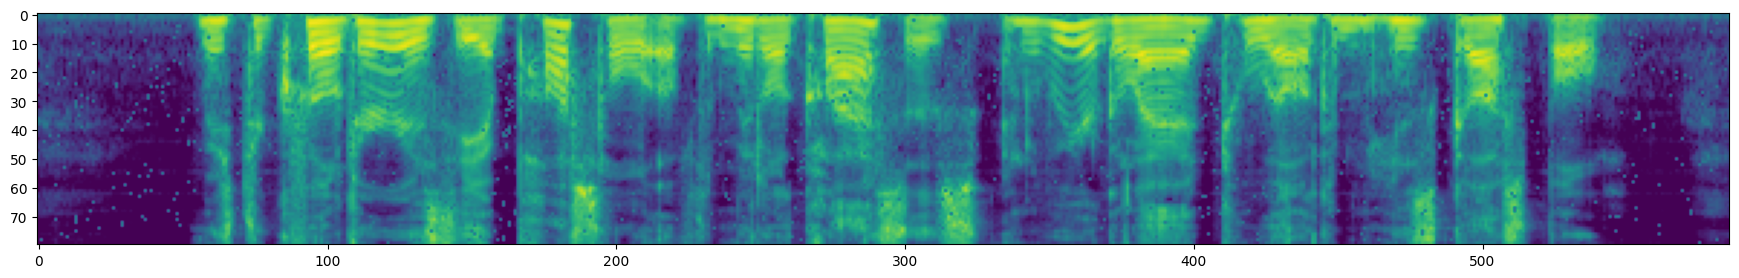

In [76]:
from matplotlib import pyplot as plt

plt.figure(figsize=(100, 3))
plt.imshow(output[0][:, :math.ceil(fraction_to_remain*output[0].shape[1])].detach().numpy())

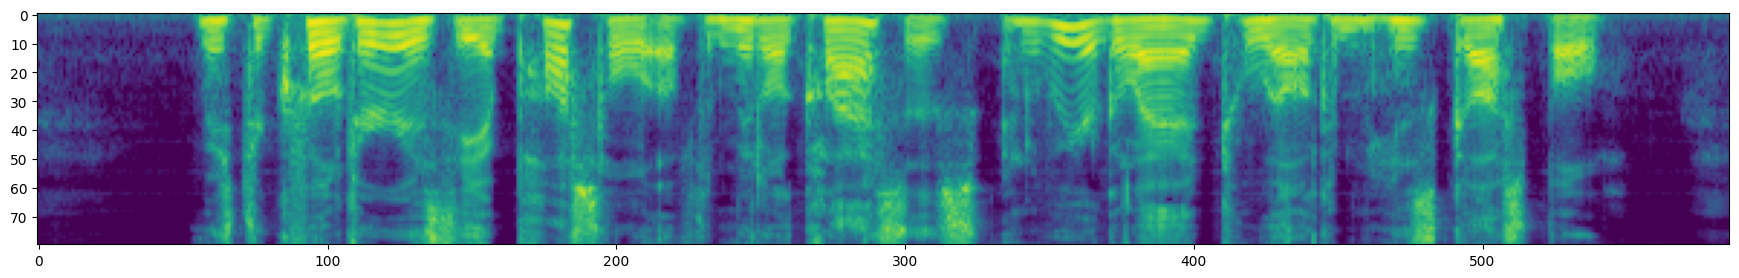

In [74]:
plt.figure(figsize=(100, 3))
plt.imshow(sample["input_features"][0][:,:math.ceil(fraction_to_remain*output[0].shape[1])].detach().numpy())

In [54]:
sample["input_features"].shape

torch.Size([1, 80, 3000])

In [73]:
math.ceil(fraction_to_remain*output[0].shape[1])

586